In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from profile_generation import *
from plotting import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit


In [3]:
%%time
# Generate profiles and join dataframes
patients_to_exclude_linear, patients_to_exclude_quad, list_of_patient_df, list_of_cal_pred_df, list_of_result_df = generate_profiles()
df, cal_pred, result_df = join_dataframes(list_of_patient_df, list_of_cal_pred_df, list_of_result_df)

# Print patients to exclude anad ouput dataframes to excel as individual sheets
print_patients_to_exclude(patients_to_exclude_linear, patients_to_exclude_quad)
output_df_to_excel(df, cal_pred, result_df)

Patient #117 has insufficient/<3 predictions (1 predictions) (for linear)!
Patient #117 has insufficient/<3 predictions (0 predictions) (for quadratic)!
Patient #121 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #126 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #130 has insufficient/<3 predictions (2 predictions) (for linear)!
Patient #130 has insufficient/<3 predictions (1 predictions) (for quadratic)!
Patient #133 has insufficient/<3 predictions (0 predictions) (for linear)!
Patient #133 has insufficient unique dose-response pairs for calibration (for quad)!
Patients to exclude for linear methods: ['117', '130', '133']
Patients to exclude for quad methods: ['117', '121', '126', '130', '133']
Wall time: 5min 37s


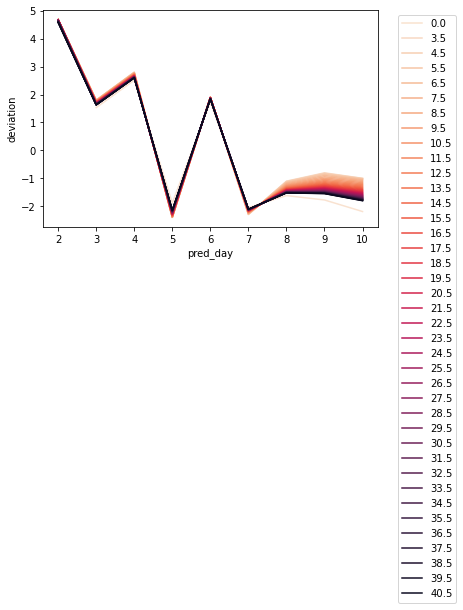

In [45]:
# How are the predictions different, between different half-lives, for each method compared to without tau?
# Plot prediction vs prediction day, for each patient, colored by tau with different half-lives vs non-tau

dat = result_df.copy()
dat = dat[['prediction', 'pred_day', 'half_life', 'method', 'patient', 'deviation']]
patient_list = dat.patient.unique()
method_list = dat.method.unique()
dat = dat[dat.patient == patient_list[6]]
dat.half_life = dat.half_life.fillna(0)
# L_Cum_origin_dp_tau
palette = sns.color_palette("rocket_r", n_colors=len(dat.half_life.unique()))
# a = np.arange(3.5, 41.5, 1)
# dat.half_life.unique()
sns.lineplot(data=dat[dat.method.str.contains("L_RW_origin_dp")], 
             x="pred_day", y="deviation", hue="half_life", 
             palette=palette, ci=None)
plt.legend(bbox_to_anchor=(1.25,1), loc='upper right')
# plt.plot(data=dat[dat.method == "L_Cum_origin_dp_tau"], 
#          x="pred_day", y="prediction", color="half_life".map())


In [ ]:
dat = result_df.copy()
dat = dat[['deviation', 'method', 'patient', 'pred_day', 'response', 'prediction', 'half_life']]
dat['half_life'] = dat['half_life'].fillna('')
dat = dat.loc[(dat.method == 'Q_Cum_origin_dp_tau') | (dat.method == 'Q_Cum_origin_dp')]
dat['new_method'] = ""
for i in range(len(dat)):
    dat['new_method'].iloc[i] = dat['method'].iloc[i] + '_' + str(dat['half_life'].iloc[i])
    # print(dat['method'].iloc[i])
plot = sns.lineplot(data=dat, x="patient", y="deviation", hue="new_method", ci=None, legend=False)
plot = sns.lineplot(data=dat.loc[dat.method=='Q_Cum_origin_dp_ '], x="patient", y="deviation", color='b', ci=None, legend=False)
# dat.head()

# sns.lineplot(data=dat.loc[dat.patient==84], x="pred_day", y="deviation", hue="method")

# dat

In [ ]:
# Plotting
# perc_days_within_target_tac(result_df)
# perc_days_outside_target_tac(result_df)
# median_perc_within_acc_dev(result_df)
# can_benefit(result_df)
# modified_TTR(result_df)
# wrong_range(result_df)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

d = {'dose': [0.5, 1, 1.5, 1.5, 3, 3], 'response': [2.4, 2.8, 3.2, 3.1, 7.9, 10]}
df = pd.DataFrame(data=d)

# Calculate weight
j = 0
decay_weight = []
for i in range(len(df)):
    decay_weight.append(math.exp(-(24*(i))/(12/np.log(2))))

# Fit model
poly_reg = PolynomialFeatures(degree=2)
X = np.array(df.dose).reshape(-1, 1)
y = np.array(df.response)
X = poly_reg.fit_transform(X)
result = LinearRegression(fit_intercept=False).fit(X, y, decay_weight)
result.coef_
# new = 3
# prediction = result.predict(poly_reg.fit_transform([[new]]))[0]
# prediction

In [ ]:
np.array(3).reshape(-1, 1)

In [8]:
a = pd.DataFrame(columns=['col1','col2'])
a = a[0:0]
a.loc[2, :] = [1, 2]

b = pd.DataFrame(columns=['col1','col2'])
b = b[0:0]
b.loc[0, :] = [1, 2]
b.loc[1, :] = [1, 2]

pd.concat([a, b])

,col1,col2
2,1,2
0,1,2
1,1,2
